### Validation of multiprobability model and post-processing steps
5.21.25

Our validation data are for one point in time. This is to assess the accuracy of our multi-probability model and post-processing steps
We match these at the monthly time step

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio

#### Import training data

Checking for typos in the Type column:
Santa Maria
	unique types ['hoop' 'mulch' 'other']
	number of rows: 1748
Watsonville
	unique types ['mulch' 'hoop' 'other' 'blackmulch' 'greenhouse']
	number of rows: 2346
Oxnard
	unique types ['hoop' 'mulch' 'blackmulch' 'other']
	number of rows: 1533
CA
	unique types ['other']
	number of rows: 165
Total number of training points: 5792
	unique types ['hoop' 'mulch' 'other' 'blackmulch' 'greenhouse']
Number of rows in each class of Type:
Type
other         2682
mulch         1527
hoop          1407
blackmulch     149
greenhouse      27
Name: count, dtype: int64
unique dates: ['2022-08-26' '2023-05-05' '2022-03-10' '2021-02-06' '2020-09-26'
 '2021-09-27' '2022-09-11' '2023-04-12' '2019-11-17' '2023-07-09'
 '2023-11-09' '2019-10-14' '2023-05-06' '2022-10-01' '2022-11-01'
 '2018-11-19' '2019-04-01' '2019-05-17' '2022-09-21' '2022-06-13'
 '2021-07-13' '2023-10-17' '2020-02-15' '2023-05-11' '2019-08-19'
 '2023-05-07' '2023-08-01' '2021-02-28' '2023-05-

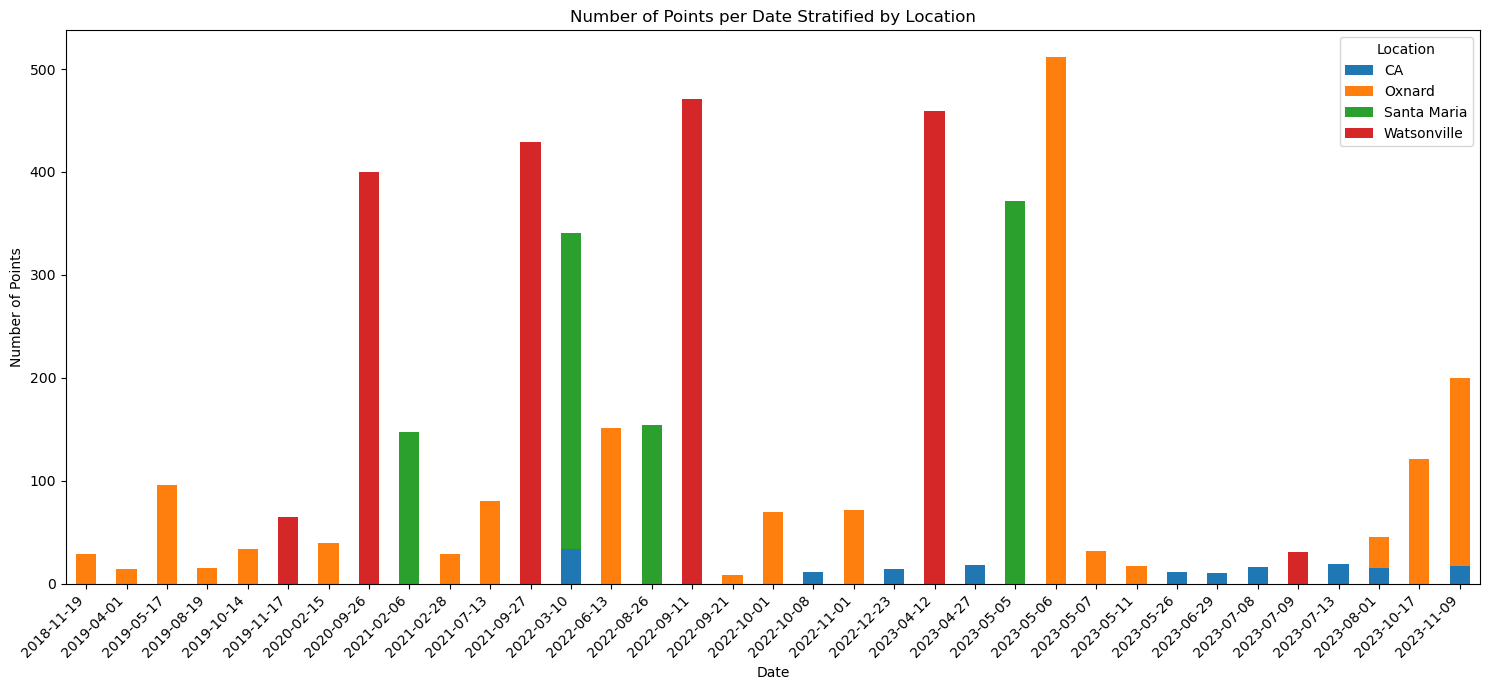

In [2]:
# Training data - local
# Import the csvs with lat/longs as dfs (could all be one csv/df, keeping separate for testing)
train_path = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/"
santamaria = pd.read_csv(train_path + 'SantaMaria_val_o.csv')
mendocino = pd.read_csv(train_path + 'MendocinoCounty_val_o.csv')
# watsonville = pd.read_csv(train_path + 'Watsonville_val.csv')
watsonville = pd.read_csv(train_path + 'Watsonville_val_BM.csv')
# replace 'black mulch' with 'blackmulch' to avoid issues with space in label
watsonville['Type'] = watsonville['Type'].replace('black mulch', 'blackmulch')
oxnard_original = pd.read_csv(train_path + 'YYT_RElabeled_points_date_fixed.csv')
# Drop the 'TARGET_FID' column from the 'oxnard' DataFrame - shouldn't need this anymore
# oxnard_original = oxnard_original.drop('TARGET_FID', axis=1)
oxnard_add = pd.read_csv(train_path + 'Oxnard_additional_val.csv')
oxnard = pd.concat([oxnard_original, oxnard_add], axis=0, ignore_index=True)
# importing new other trees dataset
othertrees = pd.read_csv(train_path + 'Brandee_Other_Trees_2025.csv')


# Print out unique 'Type' values for each df to check for typos
print('Checking for typos in the Type column:')
# all_dfs = [santamaria, mendocino, watsonville, oxnard]
all_dfs = [santamaria, watsonville, oxnard, othertrees]
for df in all_dfs:
    print(df['Location'].iloc[0])
    print('\tunique types', df['Type'].unique())
    print('\tnumber of rows:', df.shape[0])

all_data = pd.concat(all_dfs, axis=0, ignore_index=True)
print('Total number of training points:', all_data.shape[0])
print('\tunique types', all_data['Type'].unique())
print('Number of rows in each class of Type:')
print(all_data['Type'].value_counts())
# print('unique dates:', all_data['Date'].unique())

# removing unused dates from the training data to get metadata/stats

all_data_test = all_data
# remove dates before 2018-05-09
all_data_test['Date'] = pd.to_datetime(all_data_test['Date']).dt.strftime('%Y-%m-%d')
all_data_test = all_data_test[all_data_test['Date'] > '2018-05-09']
all_data_test = all_data_test[all_data_test['Type'] != 'greenhouse']
print('unique dates:', all_data_test['Date'].unique())
print('Total number of training points:', all_data_test.shape[0])
print('\tunique types', all_data_test['Type'].unique())
print('Number of rows in each class of Type:')
print(all_data_test['Type'].value_counts())
print(all_data_test['Location'].value_counts())
# display('Watsonville dates: ', all_data_test[all_data_test['Location'] == 'Watsonville']['Date'].unique())
# display('Oxnard dates: ', all_data_test[all_data_test['Location'] == 'Oxnard']['Date'].unique())
# display('Santa Maria dates: ', all_data_test[all_data_test['Location'] == 'Santa Maria']['Date'].unique())

# print a chart showing the number of points per date, stratified by Location
# Group the data by 'Date' and 'Location' and count the number of points
grouped_data = all_data_test.groupby(['Date', 'Location']).size().reset_index(name='Count')
pivot_data = grouped_data.pivot(index='Date', columns='Location', values='Count').fillna(0)
pivot_data.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Number of Points per Date Stratified by Location')
plt.xlabel('Date')
plt.ylabel('Number of Points')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Location')
plt.tight_layout()
plt.show()

In [3]:
# # get all of the oxnard data for any year
# oxnard_data = all_data_test[all_data_test['Location'] == 'Oxnard']
# # group the data by date and type and count the number of points
# oxnard_grouped = oxnard_data.groupby(['Date', 'Type']).size().reset_index(name='Count')
# # pivot the data to get a table with dates as rows and types as columns
# oxnard_pivot = oxnard_grouped.pivot(index='Date', columns='Type', values='Count').fillna(0)
# # plot the data
# oxnard_pivot.plot(kind='bar', stacked=True)
# plt.title('Oxnard Points per Date Stratified by Type')
# plt.xlabel('Date')


#### Import individual month raster and single-day training data

In [4]:
# filter all_data_test to only points from a single date/area
wats_april23 = all_data_test[all_data_test['Date'] == '2023-04-12'] # Watsonville points from April 12, 2023
ox_may23 = all_data_test[all_data_test['Date'] == '2023-05-06'] # Oxnard points from May 6, 2023
sm_may23 = all_data_test[all_data_test['Date'] == '2023-05-05'] # Santa Maria points from May 5, 2023
ox_oct_nov22 = all_data_test[all_data_test['Date'].isin(['2022-10-01', '2022-11-01'])] # oct 1 is close enough to be considered against november classification
wats_sept22 = all_data_test[all_data_test['Date'] == '2022-09-11'] # Watsonville points from September 11, 2022

# Import classification rasters for those months/areas
wats_april23_ras = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_SantaCruzCo_April2023_v1_1.tif'
ox_may23_ras = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_VenturaCo_May2023_v1_1.tif'
sm_may23_ras = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_SantaBarbaraCo_May2023_v1_1.tif'
ox_nov22_ras = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_VenturaCo_Nov2022_v1_1.tif'
wats_sept22_ras = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_SantaCruzCo_Sept2022_v1_1.tif'

# select one raster and df for analysis
raster = sm_may23_ras
df = sm_may23

print('Number of training points:', df.shape[0])

with rasterio.open(raster) as src:
    # Create a list of coordinates from the dataframe
    coord_list = [(x, y) for x, y in zip(df["Longitude"], df["Latitude"])]
    # Sample the raster at the given coordinates
    df[['month_class']] = [a for a in src.sample(coord_list)]

df.head()

Number of training points: 372


E:\Users\annalise.taylor\AppData\Local\Temp\102\ipykernel_149756\479289051.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['month_class']] = [a for a in src.sample(coord_list)]


,Location,Type,Date,Latitude,Longitude,Region,month_class
154,Santa Maria,other,2023-05-05,34.946925,-120.536196,NaN,0
155,Santa Maria,other,2023-05-05,34.951650,-120.537568,NaN,0
156,Santa Maria,other,2023-05-05,34.952624,-120.537330,NaN,0
157,Santa Maria,other,2023-05-05,34.951587,-120.530499,NaN,0
158,Santa Maria,other,2023-05-05,34.954342,-120.523804,NaN,0


#### Compare actual vs predicted values

E:\Users\annalise.taylor\AppData\Local\Temp\102\ipykernel_149756\2980107322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_class'] = df['month_class'].replace({0: 'other', 1: 'hoop', 2: 'mulch'})


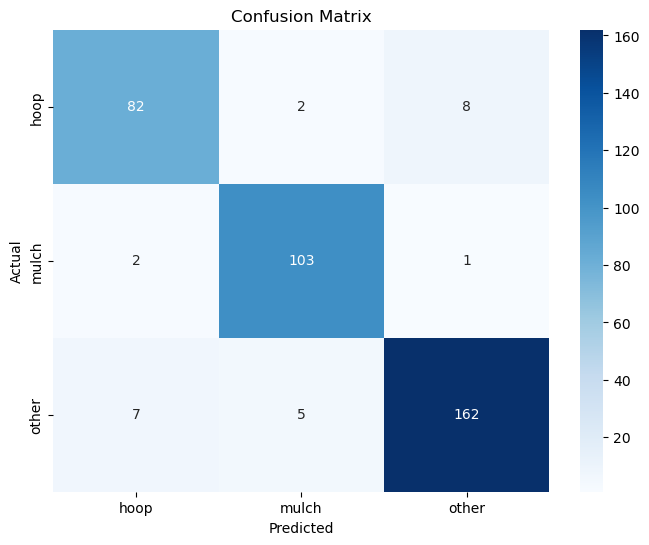

372 training points
Overall accuracy: 0.93
hoop accuracy: 0.89
mulch accuracy: 0.97
other accuracy: 0.93


In [5]:
df['month_class'] = df['month_class'].replace({0: 'other', 1: 'hoop', 2: 'mulch'})
# confusion matrix compare actual (type) to predicted (class_april23)
cm = confusion_matrix(df['Type'], df['month_class'], labels=['hoop', 'mulch', 'other'])
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['hoop', 'mulch', 'other'], yticklabels=['hoop', 'mulch', 'other'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
accuracy = np.trace(cm) / np.sum(cm)

print(f'{df.shape[0]} training points')
print(f'Overall accuracy: {accuracy:.2f}')
# print the accuracy for each class
for i, label in enumerate(['hoop', 'mulch', 'other']):
    class_accuracy = cm[i, i] / np.sum(cm[i, :])
    print(f'{label} accuracy: {class_accuracy:.2f}')

### combine all into one confusion matrix

In [6]:
# List of (dataframe, raster_path, label) tuples
samples = [
    (wats_april23, wats_april23_ras, 'wats_april23'),
    (ox_may23, ox_may23_ras, 'ox_may23'),
    (sm_may23, sm_may23_ras, 'sm_may23'),
    (ox_oct_nov22, ox_nov22_ras, 'ox_oct_nov22'),
    (wats_sept22, wats_sept22_ras, 'wats_sept22')
]

dfs = []
for df, raster, label in samples:
    df = df.copy()
    with rasterio.open(raster) as src:
        coord_list = [(x, y) for x, y in zip(df["Longitude"], df["Latitude"])]
        df['month_class'] = [a[0] for a in src.sample(coord_list)]
    df['sample_label'] = label
    dfs.append(df)

all_sampled = pd.concat(dfs, ignore_index=True)
# display(all_sampled)

print(f"Number of rows before removing null values: {all_sampled.shape[0]}")

# all_sampled.dropna(subset=['month_class'], inplace=True)
# print(f"Number of rows after removing null values: {all_sampled.shape[0]}")

Number of rows before removing null values: 1956


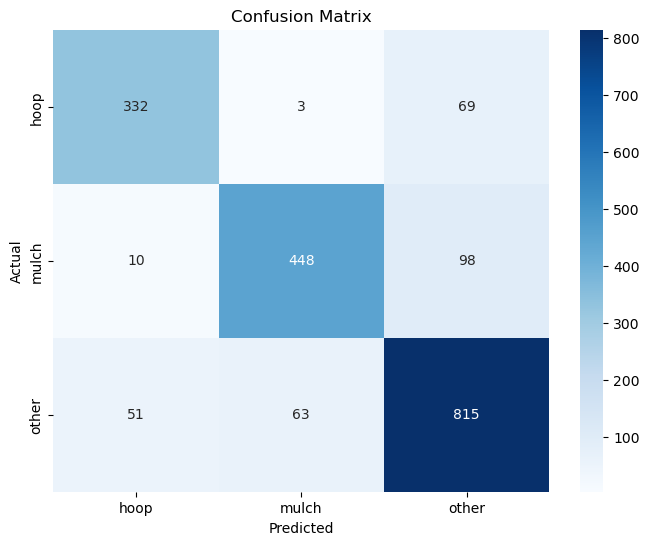

1956 training points
Overall accuracy: 84.44%
hoop accuracy: 82.18%
mulch accuracy: 80.58%
other accuracy: 87.73%


In [7]:
all_sampled['month_class'] = all_sampled['month_class'].replace({0: 'other', 1: 'hoop', 2: 'mulch'})
# confusion matrix compare actual (type) to predicted (class_april23)
cm = confusion_matrix(all_sampled['Type'], all_sampled['month_class'], labels=['hoop', 'mulch', 'other'])
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['hoop', 'mulch', 'other'], yticklabels=['hoop', 'mulch', 'other'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
accuracy = np.trace(cm) / np.sum(cm)

print(f'{all_sampled.shape[0]} training points')
print(f'Overall accuracy: {accuracy*100:.2f}%')
# print the accuracy for each class
for i, label in enumerate(['hoop', 'mulch', 'other']):
    class_accuracy = cm[i, i] / np.sum(cm[i, :])
    print(f'{label} accuracy: {class_accuracy*100:.2f}%')

#### 3-month rasters compared to training data points
Testing how far accuracy decreases

In [12]:
# filter all_data_test to only points from a single date/area
wats_april23 = all_data_test[all_data_test['Date'] == '2023-04-12'] # Watsonville points from April 12, 2023
ox_may23 = all_data_test[all_data_test['Date'] == '2023-05-06'] # Oxnard points from May 6, 2023
sm_may23 = all_data_test[all_data_test['Date'] == '2023-05-05'] # Santa Maria points from May 5, 2023
ox_oct_nov22 = all_data_test[all_data_test['Date'].isin(['2022-10-01', '2022-11-01'])] # oct 1 is close enough to be considered against november classification
wats_sept22 = all_data_test[all_data_test['Date'] == '2022-09-11'] # Watsonville points from September 11, 2022

# Import classification rasters for those months/areas
wats_april23_3mo = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_SantaCruzCo_MarAprMay2023_v1_1.tif'
ox_may23_3mo = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_VenturaCo_AprMayJun2023_v1_1.tif'
sm_may23_3mo = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_SantaBarbaraCo_AprMayJun2023_v1_1.tif'
ox_nov22_3mo = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_VenturaCo_OctNovDec2022_v1_1.tif'
wats_sept22_3mo = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_SantaCruzCo_AugSepOct2022_v1_1.tif'

# List of (dataframe, raster_path, label) tuples
samples = [
    (wats_april23, wats_april23_3mo, 'wats_april23_3mo'),
    (ox_may23, ox_may23_3mo, 'ox_may23_3mo'),
    (sm_may23, sm_may23_3mo, 'sm_may23_3mo'),
    (ox_oct_nov22, ox_nov22_3mo, 'ox_oct_nov22_3mo'),
    (wats_sept22, wats_sept22_3mo, 'wats_sept22_3mo')
]

with rasterio.open(wats_april23_3mo) as src:
    print(f"{src.count} bands")
    print(f"Band descriptions: {src.descriptions}")

dfs = []
for df, raster, label in samples:
    df = df.copy()
    with rasterio.open(raster) as src:
        coord_list = [(x, y) for x, y in zip(df["Longitude"], df["Latitude"])]
        sampled = list(src.sample(coord_list))
        df['3month_class'] = [x[0] for x in sampled]
    df['sample_label'] = label
    dfs.append(df)

all_sampled = pd.concat(dfs, ignore_index=True)
display(all_sampled)

1 bands
Band descriptions: ('class',)


,Location,Type,Date,Latitude,Longitude,Region,3month_class,sample_label
0,Watsonville,mulch,2023-04-12,36.915180,-121.833665,NaN,2,wats_april23_3mo
1,Watsonville,mulch,2023-04-12,36.914950,-121.833691,NaN,2,wats_april23_3mo
2,Watsonville,mulch,2023-04-12,36.914661,-121.833874,NaN,2,wats_april23_3mo
3,Watsonville,mulch,2023-04-12,36.915090,-121.833886,NaN,2,wats_april23_3mo
4,Watsonville,mulch,2023-04-12,36.914845,-121.833970,NaN,2,wats_april23_3mo
...,...,...,...,...,...,...,...,...
1951,Watsonville,mulch,2022-09-11,36.930563,-121.758688,NaN,2,wats_sept22_3mo
1952,Watsonville,mulch,2022-09-11,36.930200,-121.758570,NaN,2,wats_sept22_3mo
1953,Watsonville,mulch,2022-09-11,36.930274,-121.758927,NaN,2,wats_sept22_3mo
1954,Watsonville,mulch,2022-09-11,36.930440,-121.759089,NaN,2,wats_sept22_3mo


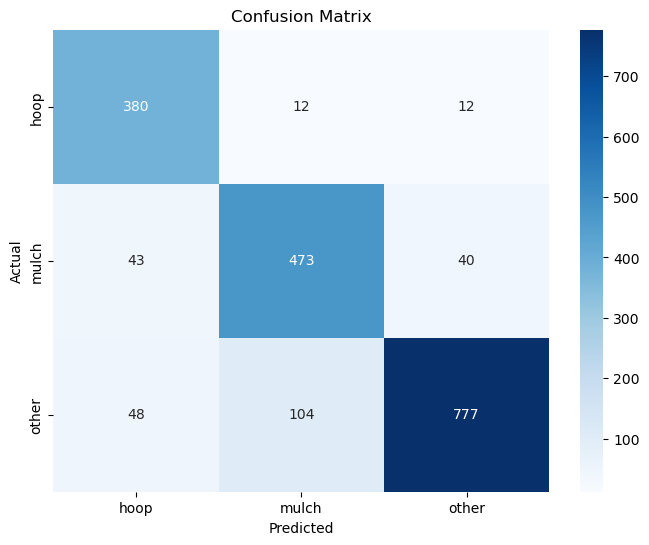

1956 training points
Overall accuracy: 86.29%
hoop accuracy: 94.06%
mulch accuracy: 85.07%
other accuracy: 83.64%


In [13]:
all_sampled['3month_class'] = all_sampled['3month_class'].replace({0: 'other', 1: 'hoop', 2: 'mulch'})
# confusion matrix compare actual (type) to predicted (class_april23)
cm = confusion_matrix(all_sampled['Type'], all_sampled['3month_class'], labels=['hoop', 'mulch', 'other'])
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['hoop', 'mulch', 'other'], yticklabels=['hoop', 'mulch', 'other'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
accuracy = np.trace(cm) / np.sum(cm)

print(f'{all_sampled.shape[0]} training points')
print(f'Overall accuracy: {accuracy*100:.2f}%')
# print the accuracy for each class
for i, label in enumerate(['hoop', 'mulch', 'other']):
    class_accuracy = cm[i, i] / np.sum(cm[i, :])
    print(f'{label} accuracy: {class_accuracy*100:.2f}%')

#### Exported monthly rasters with p95 rather than the class assignment - then ran it back through the thresholds script to test

In [9]:
wats_april23_prob = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_SantaCruzCo_April2023_prob_v1_1.tif'
ox_may23_prob = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_VenturaCo_May2023_prob_v1_1.tif'
sm_may23_prob = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_SantaBarbaraCo_May2023_prob_v1_1.tif'
ox_nov22_prob = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_VenturaCo_Nov2022_prob_v1_1.tif'
wats_sept22_prob = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/v1_1/PlasticClass_SantaCruzCo_Sept2022_prob_v1_1.tif'

# filter all_data_test to only points from a single date/area
wats_april23 = all_data_test[all_data_test['Date'] == '2023-04-12'] # Watsonville points from April 12, 2023
ox_may23 = all_data_test[all_data_test['Date'] == '2023-05-06'] # Oxnard points from May 6, 2023
sm_may23 = all_data_test[all_data_test['Date'] == '2023-05-05'] # Santa Maria points from May 5, 2023
ox_oct_nov22 = all_data_test[all_data_test['Date'].isin(['2022-10-01', '2022-11-01'])] # oct 1 is close enough to be considered against november classification
wats_sept22 = all_data_test[all_data_test['Date'] == '2022-09-11'] # Watsonville points from September 11, 2022

# List of (dataframe, raster_path, label) tuples
samples = [
    (wats_april23, wats_april23_prob, 'wats_april23'),
    (ox_may23, ox_may23_prob, 'ox_may23'),
    (sm_may23, sm_may23_prob, 'sm_may23'),
    (ox_oct_nov22, ox_nov22_prob, 'ox_oct_nov22'),
    (wats_sept22, wats_sept22_prob, 'wats_sept22')
]

with rasterio.open(wats_april23_prob) as src:
    print(f"{src.count} bands")
    print(f"Band descriptions: {src.descriptions}")

dfs = []
for df, raster, label in samples:
    df = df.copy()
    with rasterio.open(raster) as src:
        coord_list = [(x, y) for x, y in zip(df["Longitude"], df["Latitude"])]
        # Sample both bands: band 1 is hoop_p95 and band 2 is mulch_p95
        sampled = list(src.sample(coord_list))
        df['hoop_p95'] = [x[0] for x in sampled]
        df['mulch_p95'] = [x[1] for x in sampled]
    df['sample_label'] = label
    dfs.append(df)

all_sampled_probs = pd.concat(dfs, ignore_index=True)
display(all_sampled_probs)

# save as a csv for use in thresholding script
# all_sampled_probs.to_csv('N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/thresholding/MonthlyClassifications_v1_1_probs.csv', index=False)


2 bands
Band descriptions: ('hoop_p95', 'mulch_p95')


,Location,Type,Date,Latitude,Longitude,Region,hoop_p95,mulch_p95,sample_label
0,Watsonville,mulch,2023-04-12,36.915180,-121.833665,NaN,0.236984,0.679910,wats_april23
1,Watsonville,mulch,2023-04-12,36.914950,-121.833691,NaN,0.282505,0.520089,wats_april23
2,Watsonville,mulch,2023-04-12,36.914661,-121.833874,NaN,0.259268,0.737044,wats_april23
3,Watsonville,mulch,2023-04-12,36.915090,-121.833886,NaN,0.191433,0.694424,wats_april23
4,Watsonville,mulch,2023-04-12,36.914845,-121.833970,NaN,0.198677,0.709016,wats_april23
...,...,...,...,...,...,...,...,...,...
1951,Watsonville,mulch,2022-09-11,36.930563,-121.758688,NaN,0.048014,0.916403,wats_sept22
1952,Watsonville,mulch,2022-09-11,36.930200,-121.758570,NaN,0.040566,0.930372,wats_sept22
1953,Watsonville,mulch,2022-09-11,36.930274,-121.758927,NaN,0.052301,0.903674,wats_sept22
1954,Watsonville,mulch,2022-09-11,36.930440,-121.759089,NaN,0.061865,0.907491,wats_sept22
